# Object Detection with Classification & Localization

## 1. Importing Libraries

In [134]:
# Libs
import os
import numpy as np
import matplotlib.pyplot as plt
# image processing
import PIL.Image , PIL.ImageFont , PIL.ImageDraw

In [135]:
# Tensorflow Utils
import tensorflow as tf
import tensorflow_datasets as tfds

## 2. Visualization Utilities

In [136]:
# Image properties
im_width = 75
im_height = 75
use_normalized_coordinates = True

In [137]:
# Bounding Boxes
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color='red', display_str_list=None,
                               thickness=1, use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size

    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width,
                                      xmax * im_width,
                                      ymin * im_height,
                                      ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

    # draw box
    draw.line([(left, top), (left, bottom),
               (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)


def draw_bounding_boxes_on_image(image, boxes, color=None, thickness=1, display_str_list=()):
    boxes_shape = boxes.shape

    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[-1] != 4:
        raise ValueError('Input must be of size [N,4]')

    for i in range(boxes_shape[0]):
        # pick color safely
        if isinstance(color, (list, tuple)) and len(color) > i:
            c = color[i]
        elif isinstance(color, str):
            c = color
        else:
            c = "red"   # default

        # pick display string safely
        d = display_str_list[i] if len(display_str_list) > i else None

        draw_bounding_box_on_image(
            image,
            boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],
            color=c,
            display_str_list=d,
            thickness=thickness
        )


# Drawing bounding on numpy array image
def draw_bounding_boxes_on_image_array(image, boxes, color=None, thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)

    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)



In [138]:
# Long Execution Time

def dataset_to_numpy_util(training_dataset , validation_dataset):

  if tf.executing_eagerly():

    # Training Dataset
    for training_digits , (training_labels , training_bboxes) in training_dataset :
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()

    # Validation Dataset
    for validation_digits , (validation_labels , validation_bboxes) in validation_dataset :
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()


  return (training_digits , training_labels , training_bboxes ,
          validation_digits , validation_labels , validation_bboxes)


# Shorter Execution Time
def dataset_to_numpy_fast(training_dataset, validation_dataset, N):
    # Unbatch so each element is a single sample
    training_dataset = training_dataset.unbatch()
    validation_dataset = validation_dataset.unbatch()

    train_data = list(training_dataset.take(N))
    val_data   = list(validation_dataset.take(N))

    training_digits  = np.stack([x[0].numpy() for x in train_data])
    training_labels  = np.stack([x[1][0].numpy() for x in train_data])
    training_bboxes  = np.stack([x[1][1].numpy() for x in train_data])

    validation_digits = np.stack([x[0].numpy() for x in val_data])
    validation_labels = np.stack([x[1][0].numpy() for x in val_data])
    validation_bboxes = np.stack([x[1][1].numpy() for x in val_data])

    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

In [139]:
# Generating synthetic digit images from fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# n - number of images to be created
def create_digits_from_local_fonts(n):
  # font
  font_labels = []
  img = PIL.Image.new("LA" , ( 75, 75 * n ) , color =  (0 , 255))
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)

  # Draw images
  draw = PIL.ImageDraw.Draw(img)
  for i in range(n):
      font_labels.append(i % 10)
      draw.text((7 + i*75, 0 if i < 10 else -4),
            str(i % 10),
            fill=(255,255),
            font=font1 if i < 10 else font2)

  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0


  font_digits = np.reshape(
    np.stack(
        np.split(
            np.reshape(font_digits, [75, 75*n]),
            n, axis=1
        ),
        axis=0
    ),
    [n, 75*75]
  )


  return font_digits , font_labels


In [140]:
# For displaying digits with boundingboxes
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    # 10 images
    n = 10
    # randomly choosing
    indexes = np.random.choice(len(predictions), size=n)

    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes]

    if len(bboxes) > 0:
        n_bboxes = bboxes[indexes]

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        bboxes_to_plot = []

        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])

        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_digits[i],
            boxes=np.asarray(bboxes_to_plot),
            color=['red', 'green'],
            display_str_list=['True', 'Pred']
        )

        plt.xlabel(np.argmax(n_predictions[i]))
        plt.xticks([])
        plt.yticks([])

        if np.argmax(n_predictions[i]) != np.argmax(n_labels[i]):
          ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(iou) > i:
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" % (n_iou[i][0]), color=color, transform=ax.transAxes)

## 3. Loading & Preprocessing Dataset

In [141]:
strategy = tf.distribute.get_strategy()

In [142]:
# Batch size

BATCH_SIZE = 64*strategy.num_replicas_in_sync

In [143]:
def read_image_tfds(image, label):

    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)

    image = tf.reshape(image, (28,28,1))


    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)

    image = tf.cast(image, tf.float32) / 255.0

    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75

    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])



In [144]:
# Training Dataset
def get_training_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(-1)
        return dataset

In [145]:
# Validation Dataset
def get_validation_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(-1)
        return dataset


In [146]:
# datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

In [147]:
(training_digits , training_labels , training_bboxes ,
 validation_digits , validation_labels , validation_bboxes) = dataset_to_numpy_fast(training_dataset , validation_dataset , 10)

### Visualize Data

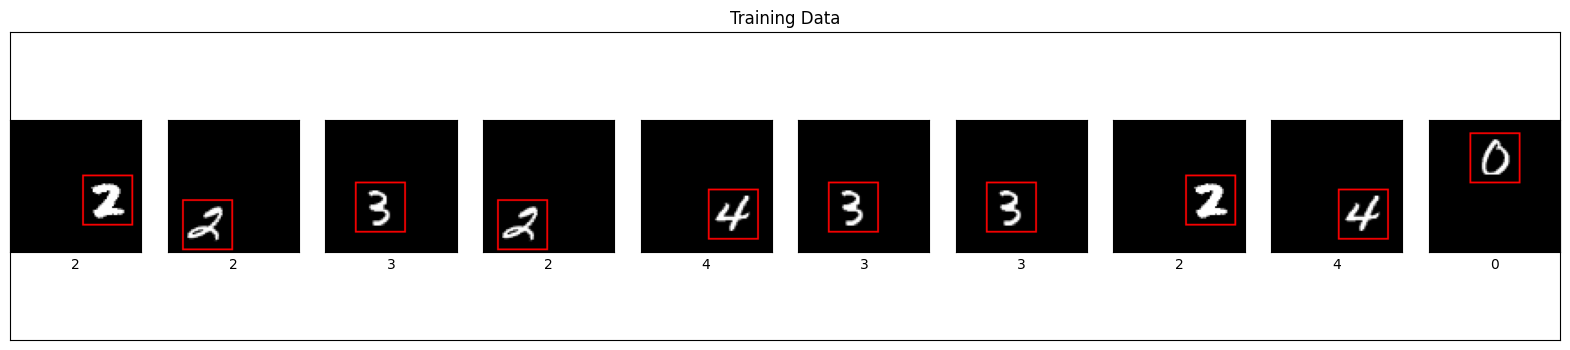

In [148]:
display_digits_with_boxes(training_digits , training_labels , training_labels, np.array([]),
                          training_bboxes , np.array([]) , "Training Data")

In [150]:
print(training_digits.shape , training_labels.shape , training_bboxes.shape )

(10, 75, 75, 1) (10, 10) (10, 4)


In [153]:
print(validation_digits.shape , validation_labels.shape , validation_bboxes.shape )

(10, 75, 75, 1) (10, 10) (10, 4)


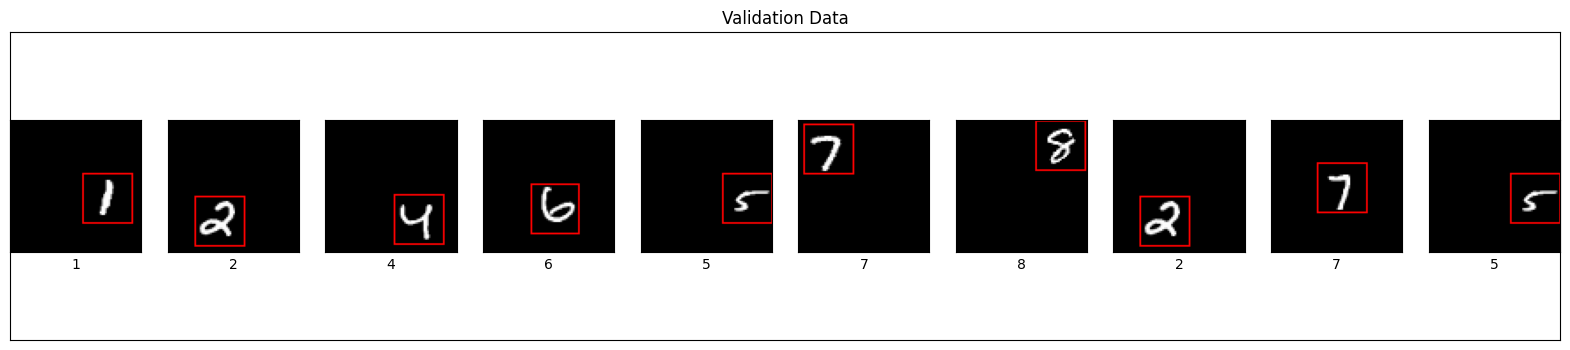

In [151]:
display_digits_with_boxes(validation_digits , validation_labels
                          , validation_labels,
                          np.array([]) , validation_bboxes , np.array([]) , "Validation Data")